<a href="https://colab.research.google.com/github/tm70/friendly-couscous/blob/master/MRI_Segmentation_U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Conv2DTranspose, Cropping2D, concatenate
from tensorflow.keras.models import Model
import cv2
import matplotlib.pyplot as plt

In [ ]:
h = 256
w = 256
c = 1
segc = 4
filters = 64
epochs = 2
n = 10

In [ ]:
data_root_orig = tf.keras.utils.get_file('/root/.keras/datasets/data',
                                         'https://cloudstor.aarnet.edu.au/plus/s/n5aZ4XX1WBKp6HZ/download',
                                         extract=True, archive_format='zip')
data_root_orig = '/root/.keras/datasets/keras_png_slices_data'

269959168/269958788 [==============================] - 26s 0us/step


In [ ]:
import pathlib
data_root_orig = '/root/.keras/datasets/keras_png_slices_data'
data_root = pathlib.Path(data_root_orig)
print(data_root)
 
for item in data_root.iterdir():
  print(item)
 
test_images = list(data_root.glob('keras_png_slices_test/*'))
test_images = [str(path) for path in test_images]
test_images.sort()
train_images = list(data_root.glob('keras_png_slices_train/*'))
train_images = [str(path) for path in train_images]
train_images.sort()
valid_images = list(data_root.glob('keras_png_slices_validate/*'))
valid_images = [str(path) for path in valid_images]
valid_images.sort()
test_goals = list(data_root.glob('keras_png_slices_seg_test/*'))
test_goals = [str(path) for path in test_goals]
test_goals.sort()
train_goals = list(data_root.glob('keras_png_slices_seg_train/*'))
train_goals = [str(path) for path in train_goals]
train_goals.sort()
valid_goals = list(data_root.glob('keras_png_slices_seg_validate/*'))
valid_goals = [str(path) for path in valid_goals]
valid_goals.sort()

/root/.keras/datasets/keras_png_slices_data
/root/.keras/datasets/keras_png_slices_data/keras_png_slices_seg_test
/root/.keras/datasets/keras_png_slices_data/keras_png_slices_seg_train
/root/.keras/datasets/keras_png_slices_data/keras_png_slices_test
/root/.keras/datasets/keras_png_slices_data/keras_png_slices_train
/root/.keras/datasets/keras_png_slices_data/keras_png_slices_seg_validate
/root/.keras/datasets/keras_png_slices_data/keras_png_slices_validate


(544, 256, 256, 1)
(9664, 256, 256, 1)
(1120, 256, 256, 1)


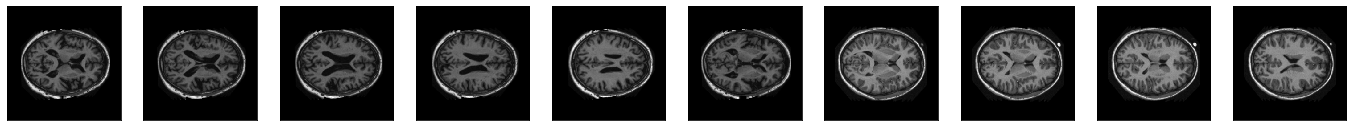

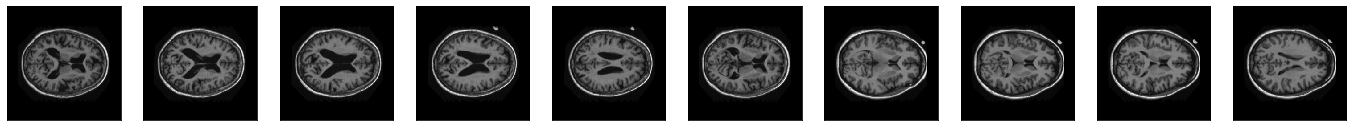

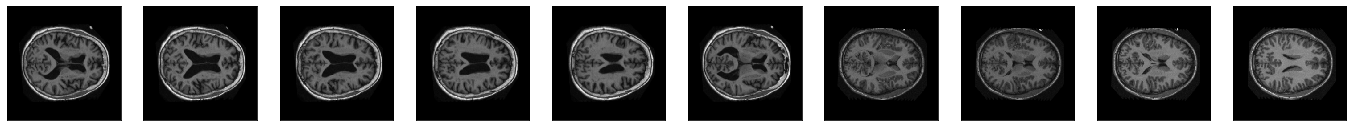

In [ ]:
x_test = []
for file in test_images:
  image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
  x_test.append(image)
x_test = np.array(x_test)[:,:,:,np.newaxis]

x_train = []
for file in train_images:
  image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
  x_train.append(image)
x_train = np.array(x_train)[:,:,:,np.newaxis]

x_valid = []
for file in valid_images:
  image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
  x_valid.append(image)
x_valid = np.array(x_valid)[:,:,:,np.newaxis]

print(x_test.shape)
print(x_train.shape)
print(x_valid.shape)

plt.figure(figsize=(24, 3))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train[i*5,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

(544, 256, 256, 4)
(9664, 256, 256, 4)
(1120, 256, 256, 4)


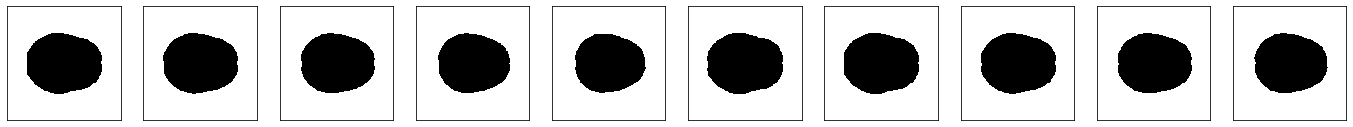

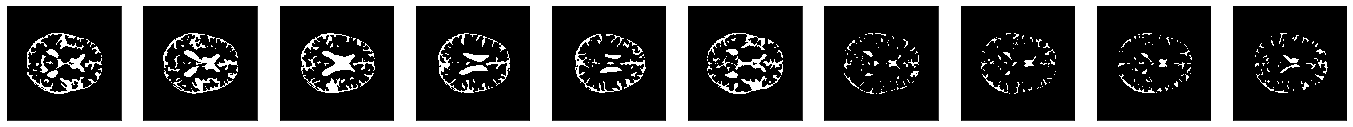

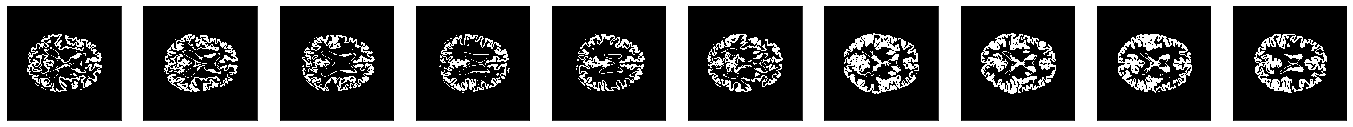

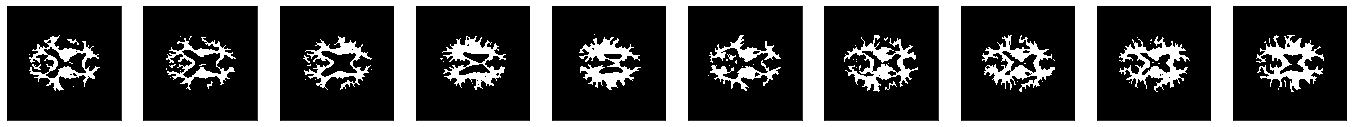

In [ ]:
y_test = []
for file in test_goals:
  image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
  # under 1
  ret, seg1 = cv2.threshold(image,1,255,cv2.THRESH_BINARY_INV)
  # between 50 and 100
  ret, seg2 = cv2.threshold(image,100,255,cv2.THRESH_TOZERO_INV)
  ret, seg2 = cv2.threshold(seg2,50,255,cv2.THRESH_BINARY)
  # between 150 and 200
  ret, seg3 = cv2.threshold(image,200,255,cv2.THRESH_TOZERO_INV)
  ret, seg3 = cv2.threshold(seg3,150,255,cv2.THRESH_BINARY)
  # above 200
  ret, seg4 = cv2.threshold(image,200,255,cv2.THRESH_BINARY)
  
  y_test.append(np.stack([seg1, seg2, seg3, seg4], axis = -1))
y_test = np.array(y_test)

y_train = []
for file in train_goals:
  image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
  # under 1
  ret, seg1 = cv2.threshold(image,1,255,cv2.THRESH_BINARY_INV)
  # between 50 and 100
  ret, seg2 = cv2.threshold(image,100,255,cv2.THRESH_TOZERO_INV)
  ret, seg2 = cv2.threshold(seg2,50,255,cv2.THRESH_BINARY)
  # between 150 and 200
  ret, seg3 = cv2.threshold(image,200,255,cv2.THRESH_TOZERO_INV)
  ret, seg3 = cv2.threshold(seg3,150,255,cv2.THRESH_BINARY)
  # above 200
  ret, seg4 = cv2.threshold(image,200,255,cv2.THRESH_BINARY)
  
  y_train.append(np.stack([seg1, seg2, seg3, seg4], axis = -1))
y_train = np.array(y_train)

y_valid = []
for file in valid_goals:
  image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
  # under 1
  ret, seg1 = cv2.threshold(image,1,255,cv2.THRESH_BINARY_INV)
  # between 50 and 100
  ret, seg2 = cv2.threshold(image,100,255,cv2.THRESH_TOZERO_INV)
  ret, seg2 = cv2.threshold(seg2,50,255,cv2.THRESH_BINARY)
  # between 150 and 200
  ret, seg3 = cv2.threshold(image,200,255,cv2.THRESH_TOZERO_INV)
  ret, seg3 = cv2.threshold(seg3,150,255,cv2.THRESH_BINARY)
  # above 200
  ret, seg4 = cv2.threshold(image,200,255,cv2.THRESH_BINARY)
  
  y_valid.append(np.stack([seg1, seg2, seg3, seg4], axis = -1))
y_valid = np.array(y_valid)

print(y_test.shape)
print(y_train.shape)
print(y_valid.shape)

plt.figure(figsize=(24, 3))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(y_train[i*5,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.figure(figsize=(24, 3))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(y_train[i*5,:,:,1])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.figure(figsize=(24, 3))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(y_train[i*5,:,:,2])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.figure(figsize=(24, 3))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(y_train[i*5,:,:,3])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#create the network
inputs = Input(shape=(h, w, c))
net1 = Conv2D(filters, (3, 3), activation="relu", padding='same')(inputs)
net2 = Conv2D(filters, (3, 3), activation="relu", padding='same')(net1)

pool1 = MaxPooling2D(pool_size=(2,2))(net2)
net3 = Conv2D(filters * 2, (3, 3), activation="relu", padding='same')(pool1)
net4 = Conv2D(filters * 2, (3, 3), activation="relu", padding='same')(net3)

pool2 = MaxPooling2D(pool_size=(2,2))(net4)
net5 = Conv2D(filters * 4, (3, 3), activation="relu", padding='same')(pool2)
net6 = Conv2D(filters * 4, (3, 3), activation="relu", padding='same')(net5)

pool3 = MaxPooling2D(pool_size=(2,2))(net6)
net7 = Conv2D(filters * 8, (3, 3), activation="relu", padding='same')(pool3)
net8 = Conv2D(filters * 8, (3, 3), activation="relu", padding='same')(net7)

up1 = Conv2DTranspose(filters * 4, (2, 2), strides=(2, 2), padding='same')(net8)
up1 = concatenate([net6, up1])
net9 = Conv2D(filters * 4, (3, 3), activation="relu", padding='same')(up1)
net10 = Conv2D(filters * 4, (3, 3), activation="relu", padding='same')(net9)

up2 = Conv2DTranspose(filters * 2, (2, 2), strides=(2, 2), padding='same')(net10)
up2 = concatenate([net4, up2])
net11 = Conv2D(filters * 2, (3, 3), activation="relu", padding='same')(up2)
net12 = Conv2D(filters * 2, (3, 3), activation="relu", padding='same')(net11)

up3 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(net12)
up3 = concatenate([net2, up3])
net13 = Conv2D(filters, (3, 3), activation="relu", padding='same')(up3)
net14 = Conv2D(filters, (3, 3), activation="relu", padding='same')(net13)

output = Conv2D(segc, (1, 1), activation="softmax")(net14)

model = Model(inputs, output)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['mean_squared_error'])
model.fit(x_train, y_train, epochs=epochs, validation_data=(x_valid, y_valid))

Train on 9664 samples, validate on 1120 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/2
9664/9664 [==============================] - 777s 80ms/sample - loss: 128.8364 - mean_squared_error: 16146.2549 - val_loss: 32.4818 - val_mean_squared_error: 16138.7822
Epoch 2/2
9664/9664 [==============================] - 758s 78ms/sample - loss: 19.6497 - mean_squared_error: 16134.8398 - val_loss: 13.5127 - val_mean_squared_error: 16133.0986


In [ ]:
predictions = model.predict(x_test)

Original


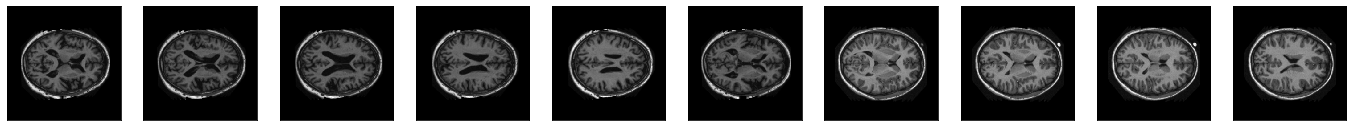

Predictions


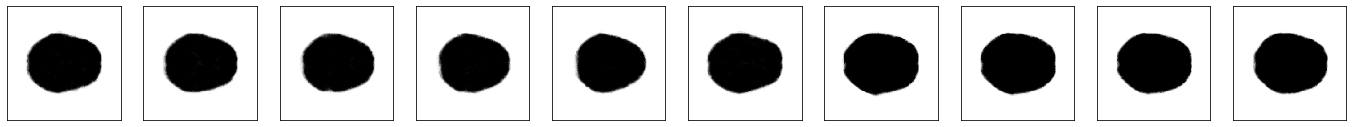

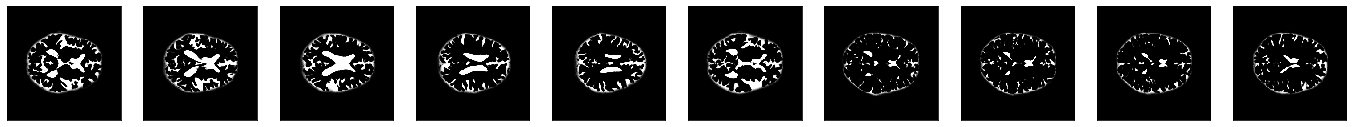

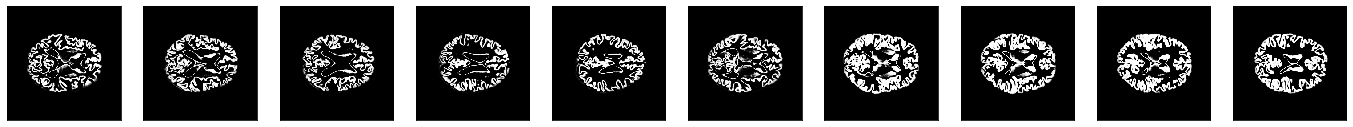

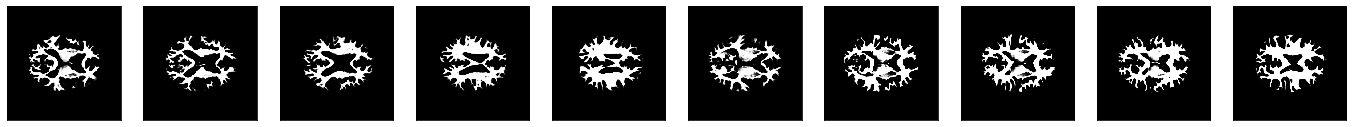

Goals


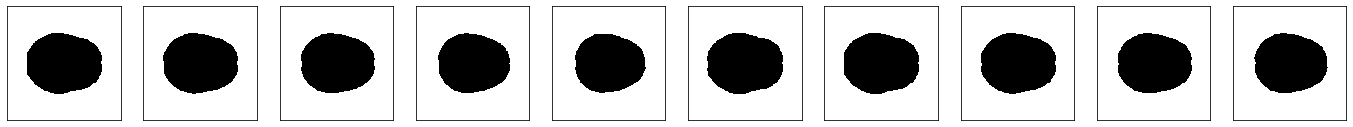

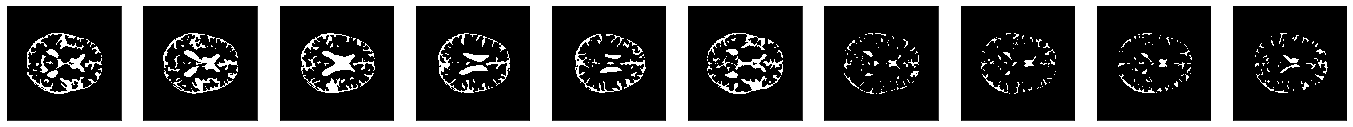

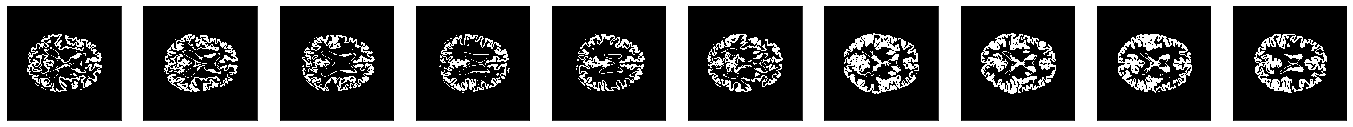

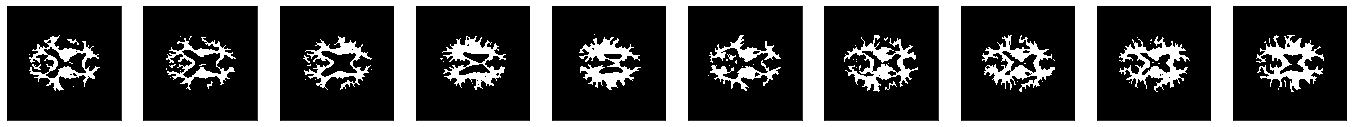

In [ ]:
print("Original")
plt.figure(figsize=(24, 3))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test[i*5,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Predictions")
plt.figure(figsize=(24, 3))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(predictions[i*5].reshape(h, w, segc)[:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.figure(figsize=(24, 3))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(predictions[i*5].reshape(h, w, segc)[:,:,1])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.figure(figsize=(24, 3))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(predictions[i*5].reshape(h, w, segc)[:,:,2])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.figure(figsize=(24, 3))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(predictions[i*5].reshape(h, w, segc)[:,:,3])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Goals")
plt.figure(figsize=(24, 3))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(y_test[i*5,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.figure(figsize=(24, 3))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(y_test[i*5,:,:,1])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.figure(figsize=(24, 3))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(y_test[i*5,:,:,2])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.figure(figsize=(24, 3))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(y_test[i*5,:,:,3])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()